In [1]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import os
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

In [2]:
#functions that get each heat budget variable calculated.
#general form so can use any dataset
def diff_T(T):
    dTdt = T.differentiate(coord = 'time',datetime_unit= 's')
    dTdx = T.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))
    dTdy = T.differentiate('lat') / (110e3 )
    dTdz = (T[:,0] - T[:,-1])/float(T.level[-1])
    return dTdt[:,:-1], dTdx[:,:-1], dTdy[:,:-1], dTdz

def advection(u, v, w, dx, dy, dz):
    uadv = u*dx
    vadv = v*dy
    wadv = w*dz
    return uadv, vadv, wadv

def get_weights(INP):
    weights = INP.level
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'level': INP.level},
                 dims=['level'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('level')
    return avg


def get_clim(dict_name):
    dict1={}
    #unpack dict, get climatology, repack
    for key in dict_name.keys():
        var = dict_name[key]
        var = var.groupby('time.month').mean('time')
        dict1[key] = var
    return dict1


In [3]:
#load in GODAS
gT = xr.open_mfdataset('/g/data/e14/sm2435/GODAS/remapcon_1/pottmp/*.nc').pottmp
gU = xr.open_mfdataset('/g/data/e14/sm2435/GODAS/remapcon_1/ucur/*.nc').ucur
gV = xr.open_mfdataset('/g/data/e14/sm2435/GODAS/remapcon_1/vcur/*.nc').vcur
gW = xr.open_mfdataset('/g/data/e14/sm2435/GODAS/remapcon_1/dzdt/*.nc').dzdt
gQ = xr.open_mfdataset('/g/data/e14/sm2435/GODAS/remapcon_1/thflx/*.nc').thflx
#get only to 50m
gT = gT[:,:5]
gU = gU[:,:5]
gV = gV[:,:5]
gW = gW[:,4]
#now put lat lon of uvw to T
gU = gU.assign_coords({'lat': gT.lat, 'lon': gT.lon})
gV = gV.assign_coords({'lat': gT.lat, 'lon': gT.lon})
gW = gW.assign_coords({'lat': gT.lat, 'lon': gT.lon})


/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: 

In [31]:
#function that will chnage date to middle of month. Uase differencing technique from other script.dtdt_manual
def date_to_middle(vari, varname):
    data_list = []
    if len(vari.dims) ==4:
        try:
            for i in range(len(vari.time)):
                val = ((vari[i,:,:,:]+vari[i+1,:,:,:])/(2)).values
                data_list.append(val)
        except:
            print('error')
        arr = np.asarray(data_list)
        test = xr.DataArray(arr, coords={'time': vari.time[:-1], 'level': vari.level, 'lat': vari.lat, 'lon':vari.lon},
                     dims=['time', 'level', 'lat', 'lon'], attrs=dict(
                description=varname))
    elif len(vari.dims)==3:
        try:
            for i in range(len(vari.time)):
                val = ((vari[i,:,:]+vari[i+1,:,:])/(2)).values
                data_list.append(val)
        except:
            print('error')
        arr = np.asarray(data_list)
        test = xr.DataArray(arr, coords={'time': vari.time[:-1], 'lat': vari.lat, 'lon':vari.lon},
                     dims=['time', 'lat', 'lon'], attrs=dict(
                description=varname))
    return test

In [32]:
#now perfrom on all godas data
gT = date_to_middle(gT, 'pottmp')
gU = date_to_middle(gU, 'ucur')
gV = date_to_middle(gV, 'vcur')
gW = date_to_middle(gW, 'dzdt')
gQ = date_to_middle(gQ, 'thflx')

error
error
error
error
error


In [27]:
len(gT.dims)

4

In [33]:
dTdtg, dTdxg, dTdyg, dTdzg = diff_T(gT)

In [34]:
uadvg, vadvg, wadvg = advection(gU, gV, gW, dTdxg, dTdyg, dTdzg)

/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


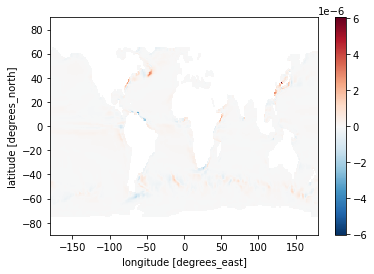

In [35]:
uadvg.mean('level').mean('time').plot()

In [36]:
#calcualate weights of levels
weights = get_weights(gT)
#now get wtd avg
dTdt_gw = weighted_avg(dTdtg, weights)
uwg = weighted_avg(uadvg, weights)
vwg = weighted_avg(vadvg, weights)
wwg = wadvg

In [37]:
#get Q
gqnet = (gQ/(3986*1026*50))

In [38]:
#now calcaulte cliamotlogy of terms
dT_cg = dTdt_gw.groupby('time.month').mean('time')
u_cg = uwg.groupby('time.month').mean('time')
v_cg = vwg.groupby('time.month').mean('time')
w_cg = wwg.groupby('time.month').mean('time')
q_cg = gqnet.groupby('time.month').mean('time')

/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [39]:
#now convert to netcdf
dT_cg.to_netcdf('/g/data/e14/sm2435/Gt_n.nc')
u_cg.to_netcdf('/g/data/e14/sm2435/Gu_n.nc')
v_cg.to_netcdf('/g/data/e14/sm2435/Gv_n.nc')
w_cg.to_netcdf('/g/data/e14/sm2435/Gw_n.nc')
q_cg.to_netcdf('/g/data/e14/sm2435/Gq_n.nc')

In [11]:
#now do the same for ec-earth3
T = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/lev_int/THETAO/*.nc').thetao
U = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/lev_int/UO/*.nc').uo
V = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/lev_int/VO/*.nc').vo
W = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/lev_int/WO/*.nc').wo
Q = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/EC-Earth3_HFDS.nc').hfds
#get only to 50m
T = T[:,:5]
U = U[:,:5]
V = V[:,:5]
W = W[:,4]
#now put lat lon of uvw to T
U = U.assign_coords({'lat': T.lat, 'lon': T.lon})
V = V.assign_coords({'lat': T.lat, 'lon': T.lon})
W = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
T = T.rename({'lev':'level'})
U = U.rename({'lev':'level'})
V = V.rename({'lev':'level'})
W = W.rename({'lev':'level'})

/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: 

In [12]:
dTdt, dTdx, dTdy, dTdz = diff_T(T)
uadv, vadv, wadv = advection(U, V, W, dTdx, dTdy, dTdz)

In [13]:
#calcualate weights of levels
weightsE = get_weights(T)
#now get wtd avg
dTdt_w = weighted_avg(dTdt, weightsE)
uw = weighted_avg(uadv, weightsE)
vw = weighted_avg(vadv, weightsE)
ww = wadv

In [14]:
qnet = (Q/(3986*1026*50))

In [15]:
#now calcaulte cliamotlogy of terms
dT_c = dTdt_w.groupby('time.month').mean('time')
u_c = uw.groupby('time.month').mean('time')
v_c = vw.groupby('time.month').mean('time')
w_c = ww.groupby('time.month').mean('time')
q_c = qnet.groupby('time.month').mean('time')

In [16]:
#now convert to netcdf
dT_c.to_netcdf('/g/data/e14/sm2435/ECt.nc')
u_c.to_netcdf('/g/data/e14/sm2435/ECu.nc')
v_c.to_netcdf('/g/data/e14/sm2435/ECv.nc')
w_c.to_netcdf('/g/data/e14/sm2435/ECw.nc')
q_c.to_netcdf('/g/data/e14/sm2435/ECq.nc')

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [17]:
#load in wind data and create climatology
UA = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/UAS/*.nc')
VA = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/VAS/*.nc')

/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: 

In [18]:
#now calculate climatology of winds
UAC = UA.uas.groupby('time.month').mean('time')
VAC = VA.vas.groupby('time.month').mean('time')

In [19]:
UAC.to_netcdf('/g/data/e14/sm2435/Ewind_u.nc')
VAC.to_netcdf('/g/data/e14/sm2435/Ewind_v.nc')

In [20]:
#load in obs U,v
NU = xr.open_dataset('/g/data/e14/sm2435/GODAS/uwnd.10m.mon.mean.nc')
NV = xr.open_dataset('/g/data/e14/sm2435/GODAS/vwnd.10m.mon.mean.nc')


In [21]:
NUC = NU.uwnd.groupby('time.month').mean('time')
NVC = NV.vwnd.groupby('time.month').mean('time')

In [22]:
#convert to netcdf
NUC.to_netcdf('/g/data/e14/sm2435/OBSwind_u.nc')
NVC.to_netcdf('/g/data/e14/sm2435/OBSwind_v.nc')

In [23]:
#decompose advection terms to see where the bias is coming from - temp or current
#GODAS
dTdxgw = weighted_avg(dTdxg, weights)
dTdygw = weighted_avg(dTdyg, weights)

gUw = weighted_avg(gU, weights)
gVw = weighted_avg(gV, weights)


In [24]:
#EC-earth
dTdxw = weighted_avg(dTdx, weightsE)
dTdyw = weighted_avg(dTdy, weightsE)

Uw = weighted_avg(U, weightsE)
Vw = weighted_avg(V, weightsE)


In [25]:
#now get climatology of these terms
dxC = dTdxw.groupby('time.month').mean('time')
dyC = dTdyw.groupby('time.month').mean('time')
dzC = dTdz.groupby('time.month').mean('time')
uC = Uw.groupby('time.month').mean('time')
vC = Vw.groupby('time.month').mean('time')
wC = W.groupby('time.month').mean('time')

dxgC = dTdxgw.groupby('time.month').mean('time')
dygC = dTdygw.groupby('time.month').mean('time')
dzgC = dTdzg.groupby('time.month').mean('time')
ugC = gUw.groupby('time.month').mean('time')
vgC = gVw.groupby('time.month').mean('time')
wgC = gW.groupby('time.month').mean('time')


In [26]:
#now calcualte the difference in each term
ddx = dxgC - dxC
ddy = dygC - dyC
ddz = dzgC - dzC
du = ugC - uC
dv = vgC - vC
dw = wgC - wC

In [27]:
#convert to netcdf
ddx.to_netcdf('/g/data/e14/sm2435/ddtdx.nc')
ddy.to_netcdf('/g/data/e14/sm2435/ddtdy.nc')
ddz.to_netcdf('/g/data/e14/sm2435/ddtdz.nc')
du.to_netcdf('/g/data/e14/sm2435/du.nc')
dv.to_netcdf('/g/data/e14/sm2435/dv.nc')
dw.to_netcdf('/g/data/e14/sm2435/dw.nc')

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide